In [ ]:
import cv2
cv2.__version__

'4.10.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score

In [ ]:
image_folder = '/content/drive/MyDrive/Colab Notebooks/MachineL/strawberry_datasets/images/ume'  # Thay đổi đường dẫn tới thư mục ảnh
image_files = os.listdir(image_folder)

In [ ]:

pip install opencv-python opencv-python-headless numpy


In [ ]:
def remove_background_from_images(img, iterations=5):
    # Thay đổi kích thước ảnh nếu cần thiết
    img_resized = cv2.resize(img,(256, 256))
    # Khởi tạo mask cho GrabCut
    mask = np.zeros(img_resized.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Khởi tạo vùng chứa đối tượng với hộp chữ nhật (có thể thay đổi rect tùy ý)
    rect = (15, 15, img_resized.shape[1] - 25, img_resized.shape[0] - 25)
    # Áp dụng thuật toán GrabCut với số lần lặp tùy chọn
    cv2.grabCut(img_resized, mask, rect, bgd_model, fgd_model, iterations, cv2.GC_INIT_WITH_RECT)
    # Thiết lập mask để phân biệt foreground và background
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')  # background -> 0, foreground -> 1

    # Tách nền và giữ lại đối tượng
    result = img_resized * mask2[:, :, np.newaxis]  # Tạo kết quả có nền được xóa

    return result


In [ ]:

def extract_color_features(image):
    # Reshape ảnh thành mảng 2D: Mỗi pixel là một dòng với 3 giá trị RGB
    pixels = image.reshape(-1, 3)

    # Loại bỏ các pixel có màu đen [0, 0, 0] hoặc màu trắng [255, 255, 255]
    non_black_white_pixels = pixels[np.all((pixels != [0, 0, 0]) & (pixels != [255, 255, 255]), axis=1)]

    # Kiểm tra nếu không có pixel hợp lệ (tức là ảnh chỉ có màu đen hoặc trắng)
    if len(non_black_white_pixels) == 0:
        return np.zeros(3)  # Trả về màu đen nếu không có pixel hợp lệ

    # Tính giá trị trung bình màu của các pixel không phải đen hoặc trắng
    mean_color = np.mean(non_black_white_pixels, axis=0)

    return mean_color.astype(np.float32)


In [ ]:
def display_images_by_cluster(image_names, features, labels, n_clusters):
    # Điều chỉnh kích thước của figure để hiển thị ảnh lớn hơn
    plt.figure(figsize=(20, 15))  # Tăng kích thước figure cho các ảnh lớn hơn

    # Tính số lượng ảnh tối đa trong một cụm
    max_images_per_cluster = max([len([image_names[i] for i in range(len(labels)) if labels[i] == cluster_id]) for cluster_id in range(n_clusters)])

    # Duyệt qua từng cụm để hiển thị ảnh
    for cluster_id in range(n_clusters):
        cluster_images = [image_names[i] for i in range(len(labels)) if labels[i] == cluster_id]
        print(f"Cluster {cluster_id + 1} contains {len(cluster_images)} images.")

        # Hiển thị ảnh trong mỗi cụm theo hàng ngang (mỗi ảnh trong một dòng)
        for i, img in enumerate(cluster_images):
            # Điều chỉnh số lượng cột theo max_images_per_cluster, và mỗi cụm sẽ có nhiều hàng
            plt.subplot(n_clusters, max_images_per_cluster, cluster_id * max_images_per_cluster + i + 1)
            plt.imshow(img)
            plt.axis('off')

            # Thêm tiêu đề cho mỗi cụm (chỉ cho ảnh đầu tiên trong mỗi cụm)
            if i == 0:
                plt.title(f'Cluster {cluster_id + 1}', fontsize=16)

    # Điều chỉnh khoảng cách giữa các hình ảnh
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Tăng khoảng cách giữa các ảnh

    # Hiển thị tất cả các hình ảnh
    plt.show()


In [ ]:
features = []
image_names = []  # Lưu tên ảnh để tham chiếu sau
image_fs = []
for image_file in image_files:
    image_full_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_full_path)
    # Tách nền và lấy các đặc trưng màu sắc
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển ảnh sang RGB trước khi xử lý
    segmented_image = remove_background_from_images(img_rgb)
    img_bgr=cv2.cvtColor(segmented_image,cv2.COLOR_RGB2BGR)# Chuyển lại sang RGB sau khi xử lý
    cv2_imshow(img_bgr)
    feature_vector = extract_color_features(img_bgr)
    features.append(feature_vector)
    image_names.append(image_file)
    image_fs.append(segmented_image)  # Lưu tên ảnh
test_features = np.array(features)


Output hidden; open in https://colab.research.google.com to view.

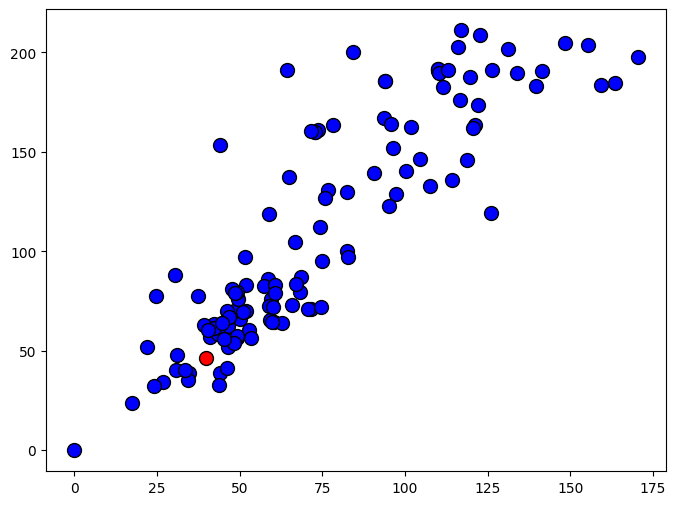

In [ ]:
def plot_feature_scatter(features):
   # Định nghĩa màu sắc cho các cụm
    colors = ['red' if label == 1 else 'blue' for label in labels]

    # Vẽ các điểm dữ liệu
    plt.figure(figsize=(8, 6))
    for i in range(len(features)):
        plt.scatter(features[i, 0], features[i, 1], color=colors[i], marker='o', edgecolor='k', s=100)

plot_feature_scatter(test_features)


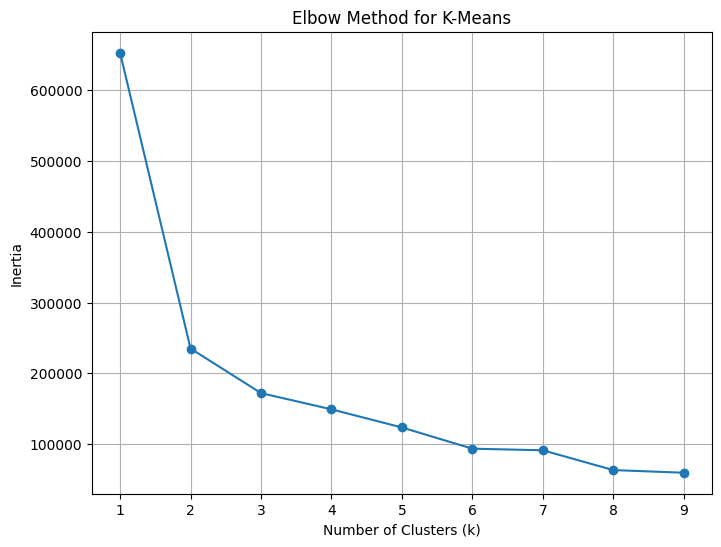

In [ ]:
inertia_values = []

# Vòng lặp qua các giá trị k từ 1 đến 10
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(test_features)
    inertia_values.append(kmeans.inertia_)

# Vẽ đồ thị Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertia_values, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Cluster 1 contains 52 images.
Cluster 2 contains 70 images.


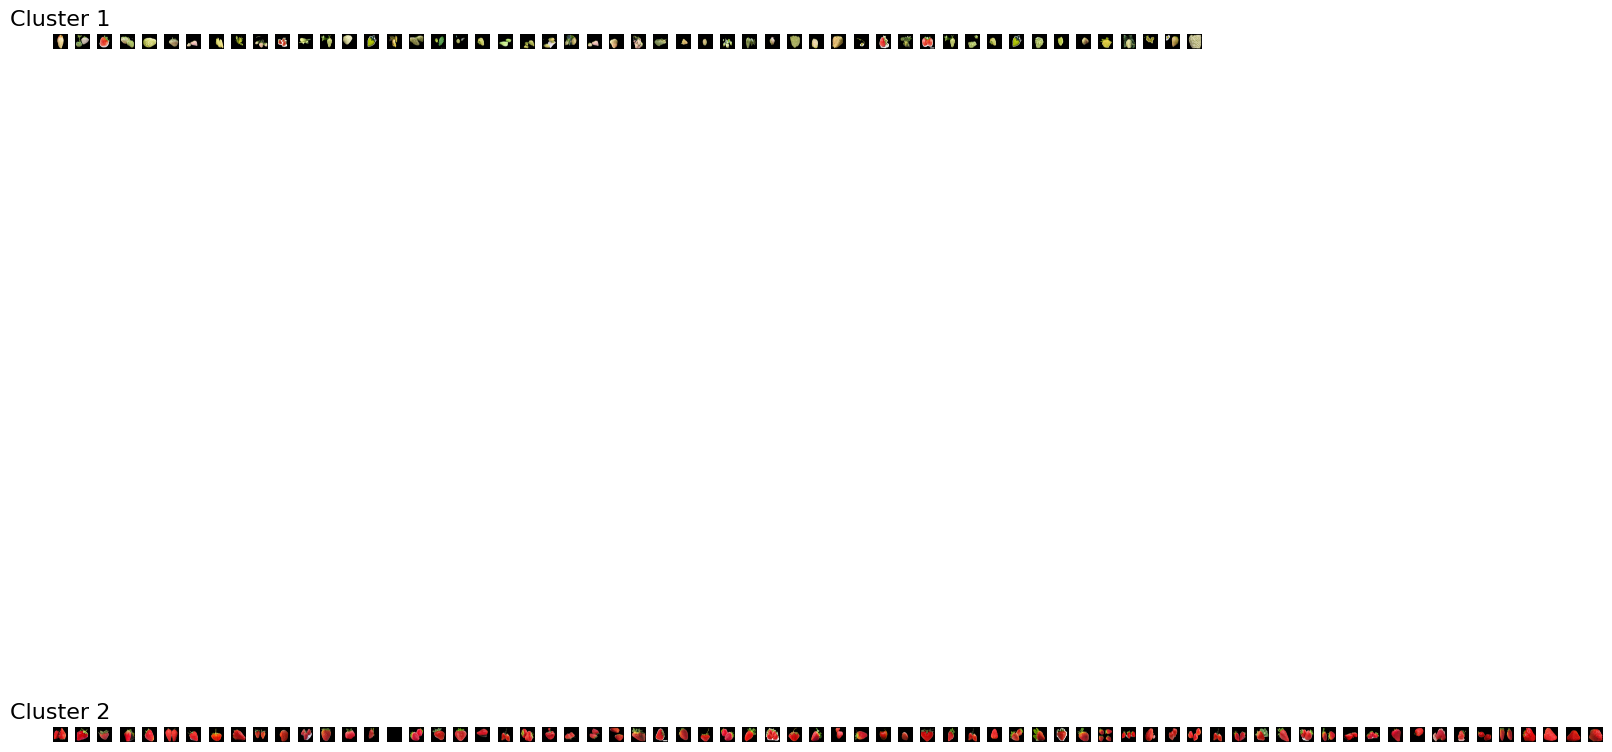

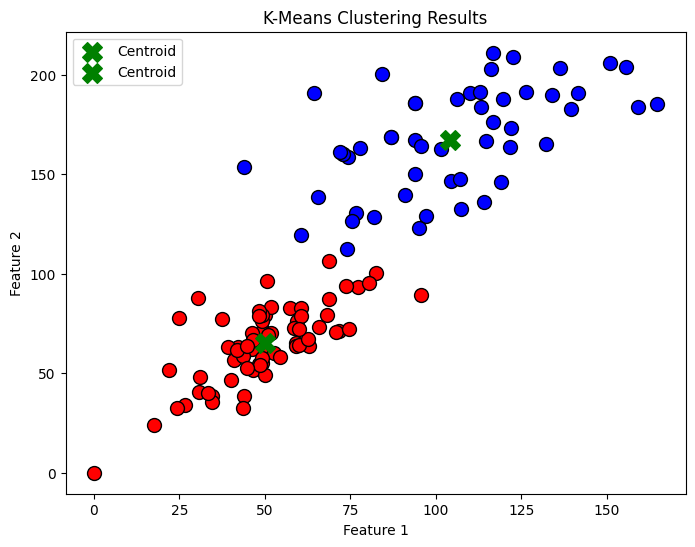

In [ ]:
# Áp dụng K-means clustering
n_clusters =2  # Số cụm bạn muốn
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_features)
labels = kmeans.labels_

# Hiển thị các ảnh theo từng cụm
display_images_by_cluster(image_fs, features, labels, n_clusters)
# Vẽ chấm cho mỗi hình ảnh
# Định nghĩa màu sắc cho các cụm
if test_features.shape[1] >= 2:  # Kiểm tra có ít nhất 2 đặc trưng
    # Định nghĩa màu sắc cho các cụm
    colors = ['red' if label == 1 else 'blue' for label in labels]

    # Vẽ các điểm dữ liệu
    plt.figure(figsize=(8, 6))
    for i in range(len(test_features)):
        plt.scatter(test_features[i, 0], test_features[i, 1], color=colors[i], marker='o', edgecolor='k', s=100)

    # Vẽ tâm cụm
    centroids = kmeans.cluster_centers_
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], color='green', marker='X', s=200, label='Centroid')  # Vẽ tâm cụm màu xanh lá

    # Thiết lập tiêu đề và nhãn cho các trục
    plt.title('K-Means Clustering Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()  # Hiện thị chú thích
    plt.show()
    #for cluster_id in range(n_clusters):
        # Lấy tên ảnh (hoặc chỉ số ảnh) cho mỗi cluster
     #   cluster_image_names = [image_names[i] for i in range(len(labels)) if labels[i] == cluster_id]
      #  print(f"Cluster {cluster_id}: {cluster_image_names}")
else:
    print("Lỗi: Các đặc trưng không có ít nhất 2 chiều để vẽ.")

Silhouette Score: 0.5753886598139849


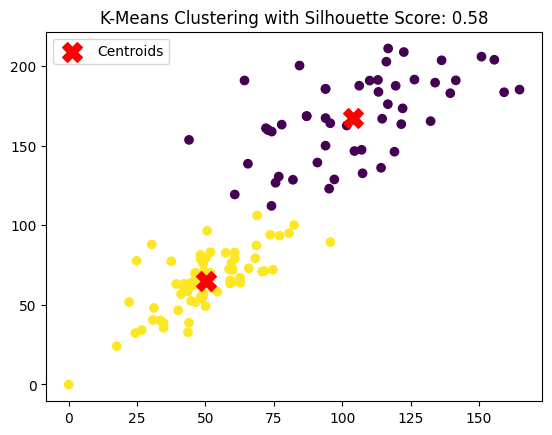

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(features, kmeans.labels_)

print(f'Silhouette Score: {silhouette_avg}')

# Vẽ dữ liệu và các tâm cụm
plt.scatter(test_features[:, 0], test_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title(f"K-Means Clustering with Silhouette Score: {silhouette_avg:.2f}")
plt.legend()
plt.show()

In [ ]:
import random
import math
import cv2
import os

class My_KMeans:
    def __init__(self, k, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None

    def euclidean_distance(self, point1, point2):
        dist = math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))
        return dist

    def fit(self, X):
        n_samples = len(X)
        n_features = len(X[0])

        # Khởi tạo centroid ngẫu nhiên từ các điểm trong dữ liệu
        random_indices = random.sample(range(n_samples), self.k)  # Chọn ngẫu nhiên k chỉ số
        self.centroids = [X[idx] for idx in random_indices]  # Lấy các điểm tương ứng với các chỉ số ngẫu nhiên

        for i in range(self.max_iters):
            # 2. Gán mỗi điểm dữ liệu vào cụm gần nhất
            labels = []
            for sample in X:
                # Tính khoảng cách giữa điểm và mỗi centroid, chọn centroid gần nhất
                distances = [self.euclidean_distance(sample, centroid) for centroid in self.centroids]
                labels.append(distances.index(min(distances)))  # Gán vào cụm có centroid gần nhất
            self.labels = labels

            # 3. Cập nhật centroid mới
            new_centroids = []
            for j in range(self.k):
                # Lấy tất cả các điểm thuộc cụm j
                cluster_points = [X[idx] for idx in range(n_samples) if labels[idx] == j]
                if cluster_points:
                    # Tính centroid mới (trung bình từng đặc trưng)
                    new_centroid = [sum(feature) / len(cluster_points) for feature in zip(*cluster_points)]
                    new_centroids.append(new_centroid)


            self.centroids = new_centroids  # Cập nhật centroid mới

        return self  # Trả lại đối tượng KMeans sau khi huấn luyện xong

    def predict(self, X):
        labels = []
        for sample in X:
            distances = [self.euclidean_distance(sample, centroid) for centroid in self.centroids]
            labels.append(distances.index(min(distances)))
        return labels

    def get_centroids(self):
        return self.centroids


# Giả sử bạn đã có dữ liệu 'test_features', 'image_names', và 'image_fs' từ trước
# test_features là danh sách chứa các đặc trưng màu sắc của các ảnh
# image_names là danh sách chứa tên các ảnh
# image_fs là danh sách chứa ảnh đã xử lý (tách nền)

# Áp dụng thuật toán KMeans để phân nhóm các ảnh
kmeans = My_KMeans(k=2)  # Giả sử bạn muốn chia thành 2 cụm (k=2)
kmeans.fit(test_features)

# Bước 3: Dự đoán nhãn cho từng ảnh
labels = kmeans.predict(test_features)



Text(0.5, 1.0, 'K-Means Clustering Results')

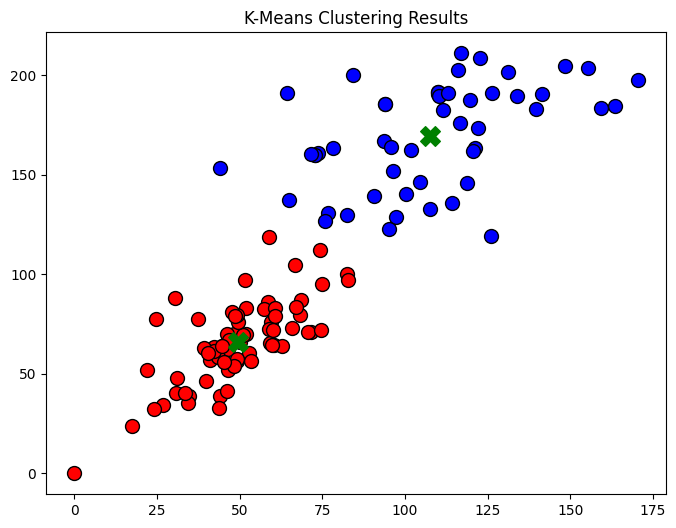

In [ ]:
import matplotlib.pyplot as plt

# Giả sử labels là kết quả phân cụm và test_features là dữ liệu đặc trưng
# Tạo danh sách màu sắc cho các điểm dữ liệu
colors = ['red' if label == 1 else 'blue' for label in labels]

# Vẽ các điểm dữ liệu
plt.figure(figsize=(8, 6))
for i in range(len(test_features)):
    plt.scatter(test_features[i, 0], test_features[i, 1], color=colors[i], marker='o', edgecolor='k', s=100)

# Lấy các centroid và vẽ tâm cụm
centroids = kmeans.get_centroids()  # Thêm dấu ngoặc để gọi hàm
for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], color='green', marker='X', s=200, label='Centroid')  # Vẽ tâm cụm màu xanh lá

# Thiết lập tiêu đề và nhãn cho các trục
plt.title('K-Means Clustering Results')




In [ ]:
from sklearn.metrics import silhouette_score

# Dự đoán nhãn của các điểm dữ liệu từ KMeans
labels = kmeans.predict(test_features)

# Tính toán điểm silhouette score
silhouette_avg = silhouette_score(test_features, labels)

# In kết quả
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.5760971099927071
